In [7]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,  WeightedRandomSampler
from PIL import Image

import sys
import torch
sys.path.append('..')
from dp_tools.lr_finder import LRFinder
from dataset import DatasetBCE, DatasetBinary, Dataset, DatasetPseudo
import torch.nn.functional as F
from torchvision.models import densenet169, resnet50, resnet152, resnet18
import mlflow.pytorch
from qhoptim.pyt import QHAdam
from pydoc import locate
from dp_tools.models import Descriptor
from dp_tools.helpers import get_class_weights, define_sampler
import numpy as np
import torch_optimizer as optim
from loss import cross_entropy

In [3]:
TRAIN = list(np.loadtxt('Data/kfolds/TRAIN_CLUST_1.txt', delimiter='\n', dtype=str))
VAL = list(np.loadtxt('Data/kfolds/VAL_CLUST_1.txt', delimiter='\n', dtype=str))
TEST = list(np.loadtxt('Data/TEST_filtered.txt', delimiter='\n', dtype=str))
ds_val = DatasetBCE(TRAIN+VAL, mode='val', augmentation=False, size=380)
ds_train = DatasetPseudo(TEST, augmentation=True, size=380)
labels = np.loadtxt('Data/hard_labels_pseudo.txt', dtype=int)
train_loader = DataLoader(dataset=ds_train,
                          num_workers=6,
                          batch_size=8,
                          shuffle=False)
val_loader = DataLoader(dataset=ds_val,
                        num_workers=6,
                        batch_size=1,
                        shuffle=False)

In [5]:
weights = get_class_weights(labels)
sampler_ = WeightedRandomSampler(weights, len(weights))
shuffle = False

In [5]:
sampler_ = None
shuffle = True

In [6]:
train_loader = DataLoader(dataset=ds_train,
                          sampler=sampler_,
                          num_workers=16,
                          batch_size=8,
                          shuffle=shuffle)
val_loader = DataLoader(dataset=ds_val,
                        num_workers=16,
                        batch_size=8,
                        shuffle=False)

In [8]:
# loss_function = F.binary_cross_entropy_with_logits
loss_function = cross_entropy

In [9]:
model_class = 'efficientnet_pytorch.EfficientNet.from_pretrained'
model_hyperparams ={
  'model_name': 'efficientnet-b4',
  'advprop': False,
  'num_classes': 3}
# model_class = 'dp_tools.models.Descriptor'
# model_hyperparams = {
#   'encoder_name':  'se_resnext50_32x4d',
#   'num_output': 3,
#   'add_dense_layer': False,
#   'pretrain': True}
# model_class = 'models_lpf.resnet.resnet50'
# model_hyperparams = {'filter_size': 3}
# model = locate(model_class)(**model_hyperparams)
# model.load_state_dict(torch.load('weights/resnet50_lpf3.pth.tar')['state_dict'])
# model.fc = torch.nn.Linear(in_features=2048, out_features=3)

In [10]:
device = torch.device('cuda:0')
model = locate(model_class)(**model_hyperparams)
model = model.to(device)
model = torch.nn.DataParallel(model).cuda()

Loaded pretrained weights for efficientnet-b4


In [15]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=1e-6,
                             weight_decay=0)#.000001)
# optimizer = optim.RAdam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr= 1e-6,
#     betas=(0.9, 0.999),
#     eps=1e-8,
#     weight_decay=0,
# )
# optimizer = QHAdam(filter(lambda p: p.requires_grad, model.parameters()),
#                            lr=1e-6,
#                            nus=[0.7, 1.0],
#                            betas=[0.995, 0.999],
#                            weight_decay=0)

In [16]:
lr_finder = LRFinder(model, optimizer, loss_function, device="cuda")
lr_finder.range_test(train_loader, val_loader, end_lr=10, num_iter=100, step_mode="exp")


 61%|██████    | 61/100 [09:14<05:59,  9.21s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


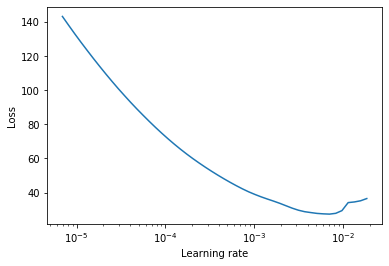

In [17]:
lr_finder.plot(skip_end=2)